<a href="https://colab.research.google.com/github/anelglvz/Deep_Learning/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split

from skimage.morphology import label

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

Data

Info de los datos en: https://www.kaggle.com/competitions/airbus-ship-detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!unzip '/content/drive/MyDrive/Curso-Deep-Learning/U-Net/sampleDir2.zip'

In [ ]:
!unzip '/content/drive/MyDrive/Curso-Deep-Learning/U-Net/train_ship_segmentations_v2.csv.zip'

Archive:  /content/drive/MyDrive/Curso-Deep-Learning/U-Net/train_ship_segmentations_v2.csv.zip
  inflating: train_ship_segmentations_v2.csv  


In [ ]:
df = pd.read_csv('train_ship_segmentations_v2.csv')
print(df.shape)
df

(231723, 2)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [ ]:
print(df.shape[0], 'masks found')
print(len(df['ImageId'].unique()), 'unique images found')

231723 masks found
192556 unique images found


In [ ]:
df[df['ImageId'] == '0005d01c8.jpg']

,ImageId,EncodedPixels
29,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
30,0005d01c8.jpg,365871 1 366638 3 367405 6 368173 7 368940 9 3...


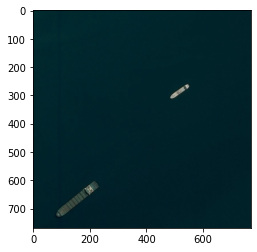

In [ ]:
aux = Image.open('/content/train_v2_2/0005d01c8.jpg')
new_image = aux.resize((100, 100))
plt.imshow(aux)
#plt.imshow(new_image)
plt.show()

In [ ]:
images = np.array(os.listdir('/content/train_v2_2'))
len(images)

17927

In [ ]:
marks = df[df['ImageId'].isin(images)]
marks

,ImageId,EncodedPixels
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
10,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
11,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
12,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
13,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...
...,...,...
231671,ffef7c3f3.jpg,476372 3 477138 5 477906 6 478674 6 479443 5 4...
231681,fff37ad60.jpg,NaN
231690,fff77c602.jpg,133056 1 133823 4 134591 6 135358 8 136126 10 ...
231704,fffb36a47.jpg,NaN


In [ ]:
def mask_part(pic):
    '''
    Function that encodes mask for single ship from .csv entry into numpy matrix
    '''
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1+int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key,marks_aux):
    '''
    Function that checks if there is a ship in image
    '''
    df = marks_aux[marks_aux['ImageId'] == key].iloc[:,1]
    if len(df) == 1 and type(df.iloc[0]) != str: #and np.isnan(df.iloc[0]):
        return True
    else:
        return False


def masks_all(key, marks_aux):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = marks_aux[marks_aux['ImageId'] == key].iloc[:,1]
    masks= np.zeros((768,768,1))
    if is_empty(key,marks_aux):
        return masks
    else:
        for i in range(len(df)):
            masks += mask_part(df.iloc[i])
        return np.transpose(masks, (1,0,2))

Randomly chosen images with corresponding masks


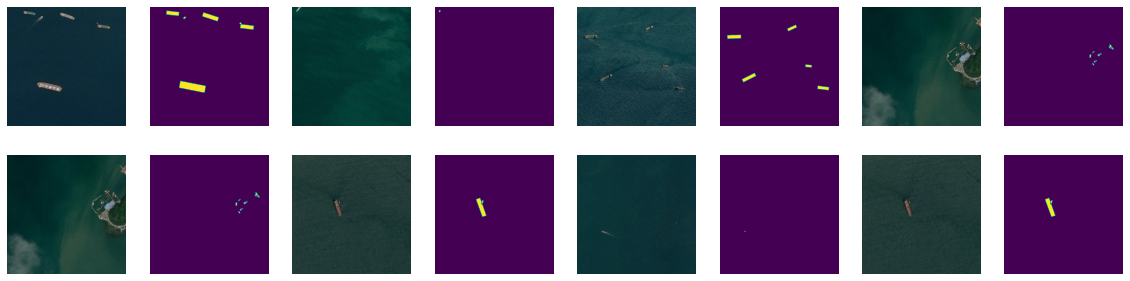

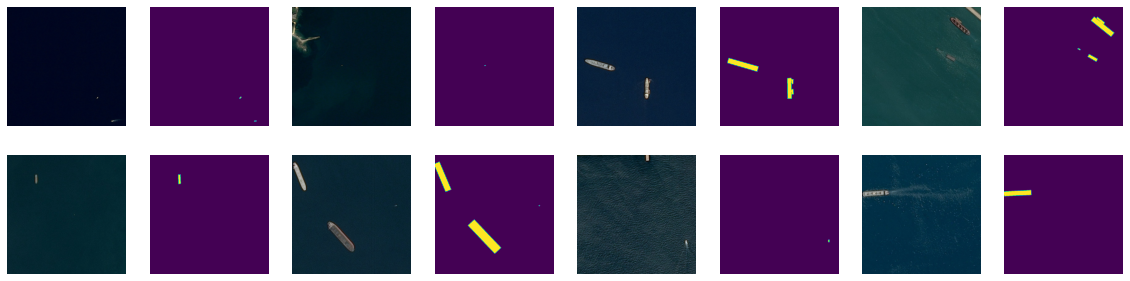

In [ ]:
def draw(lista,marks_aux):
    l = int(len(lista)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(plt.imread('/content/train_v2_2/'+lista[i]))
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        plt.imshow(masks_all(lista[i],marks_aux)[:,:,0])
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()

print('Randomly chosen images with corresponding masks')
draw(np.random.choice([i for i in images[:200] if not is_empty(i,marks)], size = 8), marks)
draw(np.random.choice([i for i in images[200:400] if not is_empty(i,marks)], size = 8), marks)
#draw(np.random.choice([i for i in images[400:600] if not is_empty(i,marks)], size = 8), marks)

In [ ]:
train_imgs, test_imgs = train_test_split(marks, test_size=0.2, random_state=69278)
train_imgs

train_fnames = train_imgs['ImageId'].values
test_fnames = test_imgs['ImageId'].values

In [ ]:
train_dpath = '/content/train_v2_2/'
test_dpath = '/content/train_v2_2/'

bst_model_fpath = '/content/drive/MyDrive/Curso-Deep-Learning/U-Net/bst_unet.model'

original_img_size = (768, 768)


In [ ]:
class param:
    img_size = (80, 80)
    bs = 32
    num_workers = 2
    lr = 0.001
    epochs = 4
    unet_depth = 3
    unet_start_filters = 8
    log_interval = 70 # less then len(train_dl)

channel_means = (0.20166926, 0.28220195, 0.31729624)
channel_stds = (0.20769505, 0.18813899, 0.16692209)

In [ ]:
def get_mask_encodings(annos, fnames):
    a = annos[annos['ImageId'].isin(fnames)]
    return a.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).to_dict()

In [ ]:
get_mask_encodings(marks, train_fnames)['17deef742.jpg']

['488152 2 488920 4 489687 7 490455 9 491222 10 491990 9 492758 9 493525 9 494293 9 495060 10 495828 9 496598 7 497368 4 498138 2']

In [ ]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    im = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        im[lo:hi] = 1
    return im.reshape(shape).T

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return ' '.join(str(x) for x in runs)

In [ ]:
class ImgDataset(Dataset):

    def __init__(self,
                 img_dpath,
                 img_fnames,
                 img_transform,
                 mask_encodings=None,
                 mask_size=None,
                 mask_transform=None):
        self.img_dpath = img_dpath
        self.img_fnames = img_fnames
        self.img_transform = img_transform

        self.mask_encodings = mask_encodings
        self.mask_size = mask_size
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        seed = np.random.randint(2147483647)

        fname = self.img_fnames[i]
        fpath = os.path.join(self.img_dpath, fname)
        img = Image.open(fpath)
        if self.img_transform is not None:
            random.seed(seed)
            img = self.img_transform(img)

        if self.mask_encodings is None:
            return img, fname

        mask = np.zeros(self.mask_size, dtype=np.uint8)
        if self.mask_encodings[fname][0] == self.mask_encodings[fname][0]: # NaN doesn't equal to itself
            for encoding in self.mask_encodings[fname]:
                mask += rle_decode(encoding, self.mask_size)
        mask = np.clip(mask, 0, 1)

        mask = Image.fromarray(mask)

        random.seed(seed)
        mask = self.mask_transform(mask)
        return img, torch.from_numpy(np.array(mask, dtype=np.int64))

    def __len__(self):
        return len(self.img_fnames)

In [ ]:
train_tfms = transforms.Compose([transforms.Resize(param.img_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(channel_means, channel_stds)])
test_tfms = transforms.Compose([transforms.Resize(param.img_size),
                               transforms.ToTensor(),
                               transforms.Normalize(channel_means, channel_stds)])
mask_tfms = transforms.Compose([transforms.Resize(param.img_size)])

train_dl = DataLoader(ImgDataset(train_dpath,
                                 train_fnames,
                                 train_tfms,
                                 get_mask_encodings(marks, train_fnames),
                                 original_img_size,
                                 mask_tfms),
                      batch_size=param.bs,
                      shuffle=True,
                      pin_memory=torch.cuda.is_available(),
                      num_workers=param.num_workers)



test_dl = DataLoader(ImgDataset(test_dpath,
                                test_fnames,
                                test_tfms),
                     batch_size=param.bs,
                     shuffle=False,
                     pin_memory=torch.cuda.is_available(),
                     num_workers=param.num_workers)


In [ ]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)
    
def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [ ]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)
        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [ ]:
class UNet(nn.Module):

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
  
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))
            
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)


        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = torch.sigmoid(self.conv_final(x))
        return x

In [ ]:
model = UNet(1,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat').cuda()   #Descomentar #.cuda() si hay GPU disponibles  
optim = torch.optim.Adam(model.parameters(), lr=param.lr)

In [ ]:
iters = []
train_losses = []

it = 0

os.makedirs(os.path.dirname(bst_model_fpath), exist_ok=True)

model.train()
for epoch in range(param.epochs):
    for i, (X, y) in enumerate(train_dl):
        X = X.cuda()
        y = y.cuda()
        outputs = model(X)  # [N, 1, H, W]

        #loss = F.cross_entropy(outputs, y)
        loss = nn.BCELoss()(outputs.reshape(outputs.shape[0], 80,80), y.to(torch.float32))

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i + 1) % param.log_interval == 0:
            it += param.log_interval * param.bs
            iters.append(it)
            train_losses.append(loss.item())

            model.eval()
            model.train()

    print('| Epoch: %d | Loss: %.4f |' \
          %(epoch, loss.item()))        

#model.eval()
torch.save(model.state_dict(), bst_model_fpath)

| Epoch: 0 | Loss: 0.0113 |
| Epoch: 1 | Loss: 0.0171 |
| Epoch: 2 | Loss: 0.0144 |
| Epoch: 3 | Loss: 0.0108 |


In [ ]:
the_model = UNet(1,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat').cuda()   #Descomentar si hay GPU disponibles 
the_model.load_state_dict(torch.load(bst_model_fpath))
#the_model.eval() 

<All keys matched successfully>

Predicciones

In [ ]:
submission = {'ImageId': [], 'EncodedPixels': []}
from skimage.morphology import binary_opening, disk, label

#model.eval()
for X, fnames in test_dl:
    X = X.cuda()
    output = model(X)
    for i, fname in enumerate(fnames):
        mask = output[i,0].data.cpu().numpy()
        mask = (mask>0.3)
        mask = Image.fromarray(mask.astype(np.uint8)).resize(original_img_size)
        mask = np.array(mask).astype(bool)

        labels = label(mask)
        encodings = [rle_encode(labels == k) for k in np.unique(labels[labels > 0])]
        if len(encodings) > 0:
            submission['ImageId'].append(fname)
            submission['EncodedPixels'].append(encodings[0])
        else:
            submission['ImageId'].append(fname)
            submission['EncodedPixels'].append(None)

In [ ]:
submission_df = pd.DataFrame(submission, columns=['ImageId', 'EncodedPixels'])
#submission_df.to_csv('submission.csv', index=False)
submission_df

,ImageId,EncodedPixels
0,2292c2f0a.jpg,413299 39 414067 39 414835 39 415603 39 416371...
1,da75fc0c3.jpg,213610 28 214378 28 215146 28 215914 28 216682...
2,4247cc4ab.jpg,7853 19 8621 19 9389 19 10157 19 10925 19 1169...
3,91ec8a044.jpg,317 29 1085 29 1853 29 2621 29 3389 29 4157 29...
4,b1dd6857d.jpg,103084 11 103852 11 104620 11 105388 11 106156...
...,...,...
7288,50d65abf2.jpg,442378 19 443146 19 443914 19 444682 19 445450...
7289,56e598ab5.jpg,None
7290,436681293.jpg,162288 10 163056 10 163824 10 164592 10 165360...
7291,d27632e9b.jpg,73834 19 74602 19 75370 19 76138 19 76906 19 7...


Randomly chosen images with corresponding masks


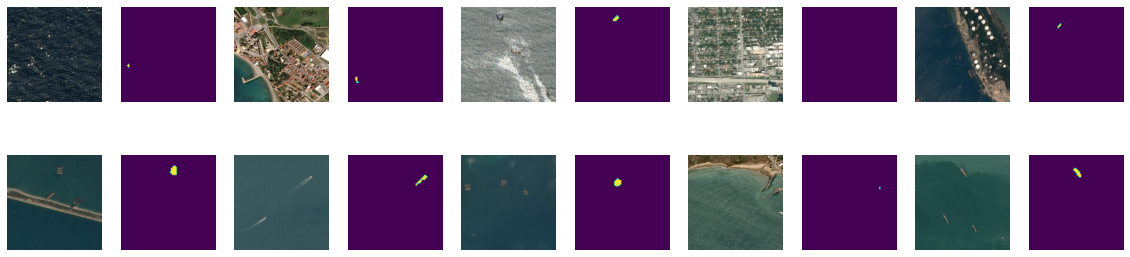

In [ ]:
print('Randomly chosen images with corresponding masks')
j = 2
draw([i for i in test_fnames[10*j:10*j+10]], submission_df)

In [ ]:
test_fnames[29]

'deebcc47a.jpg'

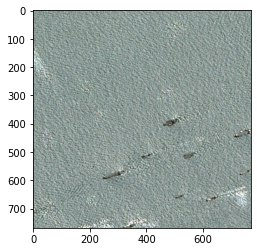

In [ ]:
aux = Image.open('/content/train_v2_2/c4a3a677d.jpg')
new_image = aux.resize((100, 100))
plt.imshow(aux)
#plt.imshow(new_image)
plt.show()

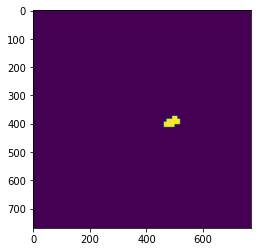

In [ ]:
plt.imshow(masks_all('c4a3a677d.jpg',submission_df)[:,:,0])

In [ ]:
submission_df.ImageId.value_counts()

ea9f82665.jpg    8
ecfdeb82a.jpg    7
6d6468e24.jpg    6
4d623f634.jpg    6
c4a3a677d.jpg    6
                ..
5c2c21a86.jpg    1
8e3ee3f87.jpg    1
a2cef6925.jpg    1
0a253b8bb.jpg    1
71aa0a219.jpg    1
Name: ImageId, Length: 5500, dtype: int64

In [ ]:
submission_df[submission_df['ImageId']== 'c4a3a677d.jpg']

,ImageId,EncodedPixels
1808,c4a3a677d.jpg,354442 19 355210 19 355978 19 356746 19 357514...
2301,c4a3a677d.jpg,354442 19 355210 19 355978 19 356746 19 357514...
2801,c4a3a677d.jpg,354442 19 355210 19 355978 19 356746 19 357514...
5950,c4a3a677d.jpg,354442 19 355210 19 355978 19 356746 19 357514...
5969,c4a3a677d.jpg,354442 19 355210 19 355978 19 356746 19 357514...
6853,c4a3a677d.jpg,354442 19 355210 19 355978 19 356746 19 357514...
